In [1]:
import numpy as np
from numba import stencil, njit

# Multigrid method for the Poisson equation
## Multigrid method V-cycle
The *multigrid method* overcomes the shortcoming of slow convergence \marginnote{In Jacobi/GS updates spread ~1 cell per iteration, MG makes this exponentially fast} of the Gauss-Seidel and Jacobi methods by using a hierarchy of grids. Information propagates faster on coarse grids, and the multigrid method uses this to accelerate the convergence exponentially. It is a *multiscale method*.The multigrid methods proceeds as follows.

Assume we have computed a numerical solution $\phi^{(n)}$ in iteration $n$, then the difference w.r.t. the true solution$\phi_\text{true}$ is given by
$$
  \chi^{(n)} = \phi^{(n)} - \phi_\text{true} \, .
$$
At the same time, the residual is defined as
$$
  r^{(n)} = \nabla^2 \phi^{(n)} - \rho \, .
$$
Applying the Laplacian to the error $\chi$, we find
$$
  \nabla^2 \chi^{(n)} =  \nabla^2 \phi^{(n)} - \nabla^2 \phi_\text{true} = r^{(n)} \, ,
$$
i.e. the error satisfies the same equation as the original problem, with the residual acting as a source term, and $\chi$ being effectively the potential of the residual. To achieve faster information propagation, we calculate the residual $r$, then we average it down to a coarser grid of resolution $N/2\times N/2$ and solve the same problem there, then interpolate the correction back down to the fine grid. This can be extended to a full recursive sweep. The residual restricted to the coarser grid is given by a simple average of the residuals on the fine grid:
$$
R_{i,j} = \frac{1}{4}\left( r_{2i,2j} + r_{2i+1,2j} + r_{2i,2j+1} + r_{2i+1,2j+1}\right).
$$
Then, we recursively solve the equation $\nabla^2 \chi = r$ on increasingly coarser grids, and subsequently correct the solution $\phi$ with the correction $\chi$ from the coarser grid, i.e. wie interpolate the correction back to the fine grid:
$$
\phi^{(n+1)}_{i,j} = \phi^{(n)}_{i,j} - \chi^{(n)}_{i/2,j/2}\,,
$$
where the indices $i/2$ and $j/2$ are rounded down to the nearest integer i.e. four fine grid points (or $2^d$ in $d$ dimensions) are corrected with the value from the same coarse grid point.

This is called a *V-cycle*, and it can be used to solve the Poisson equation in a few iterations.

### Finite difference stencil and relaxation solver
First we need to define the finite difference stencil for the Laplacian operator. And the relaxation solver that we use inside the multigrid method. We will use the red-black Gauss-Seidel method here.

In [58]:
# define the Laplacian operator and the matrix-vector product

@stencil
def laplacian_2d(u, h):
    """ 5-point stencil for 2nd order FD Laplacian in 2D """
    return (u[0, -1] + u[-1, 0] - 4 * u[0, 0] + u[1, 0] + u[0, 1]) / h**2

In [59]:
@njit
def gauss_seidel_sweep(u, f, h, N, icolor):
  """
  Perform a single in-place Gauss-Seidel sweep on the grid.

  Parameters:
  u : ndarray
    The current solution grid.
  f : ndarray
    The source term grid.
  h : float
    The grid spacing.
  N : int
    The number of interior grid points per dimension.
  icolor : int
    The color of the sweep (0 for red, 1 for black).

  Returns:
  ndarray
    The updated solution grid after the Gauss-Seidel sweep.
  """
  for i in range(1,N+1):
    for j in range(1,N+1):
      if (i+j)%2==icolor:
        u[i,j] = 0.25*(u[i-1,j]+u[i+1,j]+u[i,j-1]+u[i,j+1]-h**2*f[i,j])
  return u

## Multigrid recursion core function
This function performs the following steps:
1. Perform a few iterations of the relaxation solver on the fine grid.
2. Compute the residual $r$.
3. Restrict the residual to the coarser grid.
4. Recursively call the multigrid function on the coarser grid.
5. Interpolate the correction back to the fine grid.
6. Perform a few iterations of the relaxation solver on the fine grid to smooth out the error.
7. Return the updated solution.

In [60]:
@njit
def twogrid( phi, rho, h, N, nsmooth=4 ):
    """
    Perform a two-grid V-cycle to solve the Poisson equation.

    Parameters:
    phi : ndarray
      The current solution grid.
    rho : ndarray
      The source term grid.
    h : float
      The grid spacing.
    N : int
      The number of interior grid points per dimension.
    nsmooth : int, optional
      The number of Gauss-Seidel smoothing iterations (default is 4).

    Returns:
    ndarray
      The updated solution grid after the two-grid V-cycle.
    """
    # break the recursion if we are at the coarsest grid
    # solve directly since only one unknown
    if N == 1:
      phi[1,1] = -0.25*h**2*rho[1,1]
      return phi

    # do nsmooth iterations of Gauss-Seidel
    for i in range(nsmooth):
      phi = gauss_seidel_sweep(phi, rho, h, N, 0) # red
      phi = gauss_seidel_sweep(phi, rho, h, N, 1) # black

    # compute the residual on the fine grid
    resid = laplacian_2d(phi,h) - rho

    # restrict the residual to the coarse grid
    resid_coarse = np.zeros((N//2+2,N//2+2))
    resid_coarse[1:-1,1:-1] = 0.25*(resid[1:-1:2,1:-1:2] + resid[2:-1:2,1:-1:2] \
                                  + resid[1:-1:2,2:-1:2] + resid[2:-1:2,2:-1:2])

    # solve the coarse equation to get the coarse grid correction
    corr_coarse = np.zeros_like(resid_coarse)
    corr_coarse = twogrid( corr_coarse, resid_coarse, h*2, N//2, nsmooth )

    # correct the solution on the fine grid using the coarse grid correction
    phi[1:-1:2,1:-1:2] -= corr_coarse[1:-1,1:-1]
    phi[2:-1:2,1:-1:2] -= corr_coarse[1:-1,1:-1]
    phi[1:-1:2,2:-1:2] -= corr_coarse[1:-1,1:-1]
    phi[2:-1:2,2:-1:2] -= corr_coarse[1:-1,1:-1]

    # do nsmooth iterations of Gauss-Seidel
    for i in range(nsmooth):
      phi = gauss_seidel_sweep(phi, rho, h, N, 0) # red
      phi = gauss_seidel_sweep(phi, rho, h, N, 1) # black

    return phi

## Main driver function
This function calls the recursive multigrid function for multiple iterations, checks the error, and interupts the iterations if error is small enough.

In [61]:
def solve_poisson_2d_multigrid(rho, h, tol=1e-6, nsmooth=4, maxit=20, verbose=False):
    """Solves the 2D Poisson equation using the multigrid method
          with zero Dirichlet boundary conditions.
    
    Parameters:
          rho (ndarray): density, shape (N+2,N+2)
          h (float): grid spacing
          N (int): number of grid points
          tol (float, optional): error tolerance. Defaults to 1e-6.
    
    Returns:
          ndarray: potential, shape (N+2,N+2)
    """
    N = rho.shape[0]
    phi = np.zeros((N+2,N+2))
    # Pad f to include ghost boundaries
    rhs = np.zeros((N + 2, N + 2))
    rhs[1:-1, 1:-1] = rho

    for it in range(maxit):
      phi_old = phi.copy()
      phi = twogrid(phi, rhs, h, N, nsmooth)
      err = np.max(np.abs(phi-phi_old)) # determine L_infinity error
      if verbose:
        print(f'Iteration {it}: Linf error = {err:4g}')
      if err < tol:
         break
    if err > tol:
      print(f'Warning: did not converge in {it} iterations, final error = {err:4g}')
    return phi

## Example usage

In [62]:
# Example usage: single point source in the center
N = 64
h = 1.0 / (N + 1)
rho = np.zeros((N,N))
rho[N//2,N//2] = 1.0

phimg = solve_poisson_2d_multigrid( rho, h, tol=1e-6, verbose=True) 

Iteration 0: Linf error = 0.000202543
Iteration 1: Linf error = 1.02356e-05
Iteration 2: Linf error = 3.67321e-06
Iteration 3: Linf error = 1.57954e-06
Iteration 4: Linf error = 6.92269e-07


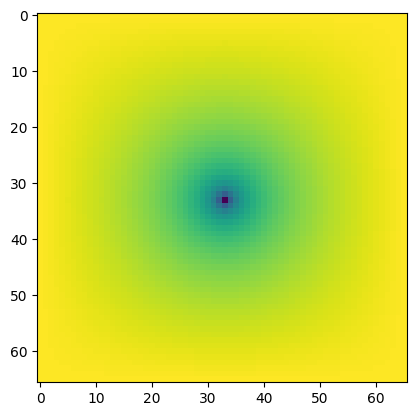

In [63]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

ax.imshow(phimg)